# Experiments with QUIMB
## Imports

In [1]:
import quimb as qu
from quimb import tensor as qtn

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import torch
import numpy as np
import scipy as sp
import cupy as cp
from tqdm.notebook import tqdm

## Code examples from quimb official site

In [4]:
data = qu.bell_state('psi-').reshape(2, 2)
inds = ('k0', 'k1')
tags = ('KET',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket

Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET']))

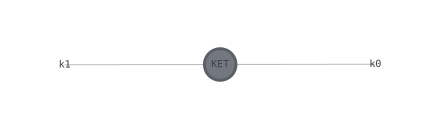

In [22]:
ket.draw()

In [23]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags=['PAULI', 'X', '0'])
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags=['PAULI', 'Y', '1'])
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags=['BRA'])
X

Tensor(shape=(2, 2), inds=('k0', 'b0'), tags=oset(['PAULI', 'X', '0']))

In [24]:
TN = ket.H & X & Y & bra
TN

TensorNetwork(tensors=4, indices=4)

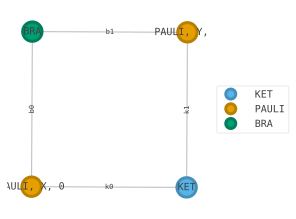

In [ ]:
TN.draw(color=['KET', 'PAULI', 'BRA'], figsize=(4, 4), show_inds='all')

In [25]:
TN ^ ...

(0.027295809086150133+0.2762115381581639j)

## Let's try to build a TTN

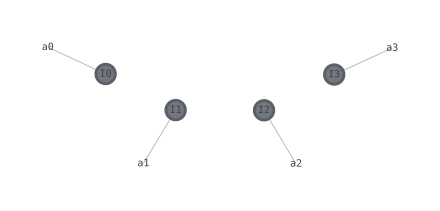

In [38]:
# generating a random MPS

ket_mps = qtn.MPS_rand_state(4, 1, site_ind_id='a{}')
ket_mps.draw()

In [39]:
ket_mps

MatrixProductState(tensors=4, indices=7, L=4, max_bond=2)

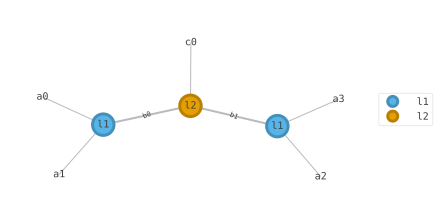

TensorNetwork(tensors=3, indices=7)

In [27]:
T1 = qtn.rand_tensor((2,2,4), inds=('a0', 'a1', 'b0'), tags=['l1'])
T2 = qtn.rand_tensor((2,2,4), inds=('a2', 'a3', 'b1'), tags=['l1'])
T3 = qtn.rand_tensor((4, 4, 2), inds=('b0', 'b1', 'c0'), tags=['l2'])

TN = T1 & T2 & T3
TN.draw(color=['l1', 'l2'], show_inds='all')
TN

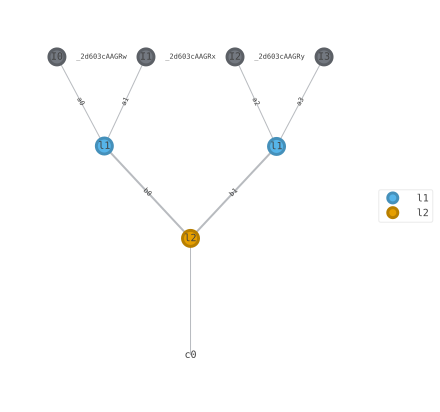

In [28]:
(TN & ket_mps).draw(color=['l1', 'l2'], show_inds='all', fix={'I{}'.format(i): (i, 5) for i in range(4)} )

In [29]:
contr = (TN & ket_mps).contract(..., backend='cupy')

In [31]:
contr.data

array([-4.49300185, -0.65061172])

# Try a TTN on MNIST
## Define TTN class

In [79]:
class TTN(qtn.TensorNetwork):
    def __init__(self, n_features, n_phys=2, n_labels=2, bond_dim=4):

        super(TTN, self).__init__()

        if (n_features % 2) != 0:
            raise ValueError(f"n_features must be  power of 2, got: {n_features}")
        
        self.n_features = n_features
        self.n_phys     = n_phys
        self.n_hlayers  = int(np.log2(n_features))-1
        self.n_labels   = n_labels
        self.bond_dim   = bond_dim


    def build(self):

        # add first tensor with special index
        if not self.n_hlayers:

            return qtn.TensorNetwork(
                [qtn.rand_phased(shape = (self.n_phys, self.n_phys, self.n_labels),
                                inds  = ['00.000', '00.001', 'label'],
                                tags  = ['l0']
                )/self.n_features*2]
            )
        else:
            tensors = [qtn.rand_phased(shape = (self.bond_dim, self.bond_dim, self.n_labels),
                                       inds  = ['00.000', '00.001', 'label'],
                                       tags  = ['l0']
                       )/self.n_features*2]


        for l in range(1, self.n_hlayers):
            
            tensors.extend([qtn.rand_phased(shape = [self.bond_dim]*3,
                                inds  = [f'{l:02}.{2*i:03}', f'{l:02}.{2*i+1:03}', f'{(l-1):02}.{i:03}'],
                                tags  = [f'l{l}']
                            )/self.n_features*2 for i in range(2**l)]
            )

        tensors.extend([qtn.rand_phased(shape = [self.n_phys]*2+[self.bond_dim],
                                inds  = [f'{self.n_hlayers:02}.{2*i:03}', f'{self.n_hlayers:02}.{2*i+1:03}', f'{(self.n_hlayers-1):02}.{i:03}'],
                                tags  = [f'l{self.n_hlayers}']
                        )/self.n_features*2 for i in range(2**self.n_hlayers)]
                        )

        self.net = qtn.TensorNetwork(tensors)
        return self.net

        

In [80]:
MyTTN = TTN(64)

In [68]:
net = MyTTN.build()
net

TensorNetwork(tensors=63, indices=127)

In [116]:
net.tensor_map.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

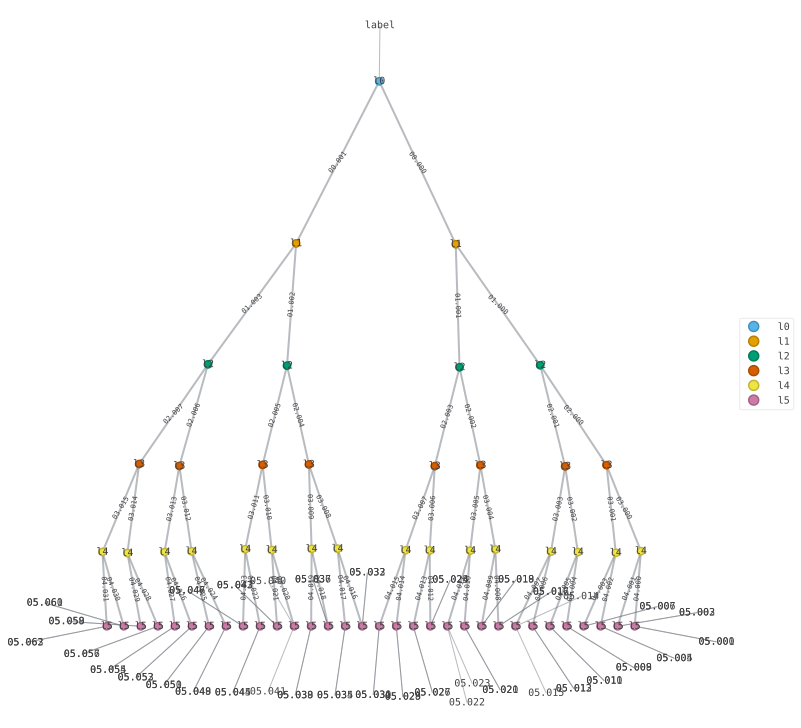

In [7]:
fig = net.draw(color=net.tags, show_inds='all', 
         fix=dict({ key : (4*i/MyTTN.n_features-1., -1.) for i, key in enumerate(list(net.tensor_map.keys())[:-MyTTN.n_features//2-1:-1])}, **{'l0':(0., 1.)}),
         return_fig=True,
         dim=2,
         figsize=(15,10)
)


In [74]:
fig.savefig('ttn.pdf')

## Let's try to train
### Preprocess

In [69]:
import torchvision as tv

h = 8

def linearize(tensor: torch.Tensor):

    result = torch.clone(tensor).reshape((-1, np.prod(tensor.shape[-2:])))
    index = torch.as_tensor(range(result.shape[-1]))
    mask = index // 2 % 2 == 0

    for i in range(tensor.shape[-1]):
        result[:, (mask != i%2) & (index < (i//2+1)*2*tensor.shape[-1]) & (index >= (i//2)*2*tensor.shape[-1])]= tensor[:,i,:]

    return result

def quantize(tensor: torch.Tensor):

    cos = torch.cos(torch.pi*tensor/2)
    sin = torch.sin(torch.pi*tensor/2)

    return torch.stack([cos, sin], dim=-1)


transform = tv.transforms.Compose([tv.transforms.Resize((h, h)), 
                                   tv.transforms.ToTensor(), 
                                   tv.transforms.Lambda(linearize), 
                                   tv.transforms.Lambda(quantize)]
            )


mnist_test  = tv.datasets.MNIST('data', download=True, train=False, transform=transform)
mnist_train = tv.datasets.MNIST('data', download=True, train=True, transform=transform)

In [70]:
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=64)
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=64)

In [81]:
MyTTN = TTN(h**2, n_labels=10)
net = MyTTN.build()

In [72]:
def norm(tn : qtn.TensorNetwork):
    return tn.isometrize(method="cayley")

In [73]:

class TNModel(torch.nn.Module):

    def __init__(self, myttn: TTN):
        super().__init__()
        # extract the raw arrays and a skeleton of the TN
        self.myttn = myttn
        myttn.build().apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.complex128, device='cuda'))
        
        params, self.skeleton = qtn.pack(myttn.net)
        # n.b. you might want to do extra processing here to e.g. store each
        # parameter as a reshaped matrix (from left_inds -> right_inds), for 
        # some optimizers, and for some torch parametrizations
        self.torch_params = torch.nn.ParameterDict({
            # torch requires strings as keys
            str(i): torch.nn.Parameter(initial)
            for i, initial in params.items()
        })

    def forward(self, x: torch.Tensor):
        # convert back to original int key format
        params = {int(i): p for i, p in self.torch_params.items()}
        # reconstruct the TN with the new parameters
        tn = qtn.unpack(params, self.skeleton)
        results=[]

        for datum in x:
            contr = (qtn.MatrixProductState(torch.unbind(datum.unsqueeze(0), -2), site_ind_id=f'{self.myttn.n_hlayers:02}.{{:03}}') & tn) ^ ...
            results.append(contr.data)
        # isometrize and then return the energy
        return torch.stack(results)

In [82]:
model = TNModel(MyTTN)

In [13]:
x, y = next(iter(train_dl))
#qtn.MatrixProductState(torch.unbind(x[0].unsqueeze(0), -2), site_ind_id=f'{MyTTN.n_hlayers:02}.{{:03}}').draw()

In [83]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [76]:

def train_one_epoch():
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    pbar = tqdm(enumerate(train_dl), total=len(train_dl),position=0 ,leave=False)
    for i, data in pbar:

        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to('cuda', dtype=torch.complex128), labels.to('cuda')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        probs = torch.abs(outputs).to('cpu')

        # Compute the loss and its gradients
        loss = loss_fn(torch.nn.functional.one_hot(labels).to('cpu',dtype=torch.float64), probs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
        pbar.set_postfix({'loss': running_loss / (i+1)})
    return last_loss


In [84]:
model.train()
train_one_epoch()

  0%|          | 0/938 [00:00<?, ?it/s]

  batch 100 loss: 3.389862852699221e-76
  batch 200 loss: 3.407987120508579e-76
  batch 300 loss: 3.508299709329706e-76
  batch 400 loss: 3.36235121492491e-76
  batch 500 loss: 3.541261907788708e-76
  batch 600 loss: 3.428252678974986e-76
  batch 700 loss: 3.4007487604483436e-76
  batch 800 loss: 3.532572904874821e-76
  batch 900 loss: 3.480617674275129e-76


3.480617674275129e-76

In [24]:
torch.save(model.state_dict, 'trainedmodel64.dict')

In [61]:
with torch.no_grad():
    model.eval()
    inputs, labels = next(iter(train_dl))
    result = model(inputs.to('cuda', dtype=torch.complex128))
result

tensor([[ 4.8549e-108-1.5368e-108j,  9.6914e-108+6.6047e-108j,
         -9.2935e-108+1.3853e-107j, -8.7082e-108+5.0073e-108j,
         -4.2618e-110-3.0867e-108j,  1.6294e-107-2.5109e-108j,
          1.5201e-107+6.9363e-108j,  1.4277e-108-5.9943e-108j,
         -2.5991e-108-1.0401e-108j,  7.8809e-108-7.4145e-109j],
        [ 2.6574e-108+2.1012e-108j,  2.6354e-108+9.2198e-109j,
         -2.1647e-109+4.9261e-108j, -4.5791e-108+2.7633e-108j,
         -1.2759e-108-8.6138e-109j,  3.9354e-109-4.2496e-108j,
         -1.7968e-108+6.1832e-109j,  1.9729e-109-4.4380e-109j,
          3.0423e-109+1.5153e-108j, -1.0828e-109-1.2648e-108j],
        [-2.3503e-108-8.5993e-109j, -1.7476e-108+2.0538e-109j,
          1.9395e-108-9.5706e-109j,  3.6727e-109-1.9221e-108j,
          1.0738e-108+9.9983e-109j, -9.3735e-109+1.7797e-108j,
         -1.3470e-108+9.3235e-109j, -5.7335e-109-2.3572e-108j,
         -2.6526e-109-9.9096e-109j,  4.5878e-109-1.8581e-108j],
        [-1.0157e-108+2.8879e-108j, -3.2180e-109+3.0

In [62]:
probs = torch.abs(result).to('cpu')

# Compute the loss and its gradients
loss = loss_fn(torch.nn.functional.one_hot(labels).to('cpu',dtype=torch.float64), probs)


In [63]:
loss

tensor(1.7209e-106, dtype=torch.float64)